In [1]:
#Imports
import math
import librosa
import librosa.display
import IPython.display as ipd

import pyAudioAnalysis
import pydub
import ffmpeg
import os
import sklearn

from pydub import AudioSegment
from pydub.silence import split_on_silence

import numpy
import numpy as np
import matplotlib.pyplot as plt

import xlwt
from xlwt import Workbook

from numpy import sin, cos, pi, linspace, arange, log10, absolute
from numpy.random import randn
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter, freqz, welch
from scipy.io.wavfile import read , write
from scipy.signal import spectrogram
from matplotlib import pyplot
from matplotlib.pyplot import ylabel, xlabel
from matplotlib.pyplot import plot, legend, show, grid, figure, savefig#, hold

C:\Users\Dasil\anaconda3\envs\PDS\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [ ]:
os.chdir('C:/Users/lemos/PDS/TP')
os.getcwd()

In [2]:
#Cepstrum and Power Spectrum

def real_cepstrum(x, n=None):
# Compute the real cepstrum of a real sequence
#    x : ndarray
#        Real sequence to compute real cepstrum of.
#    n : {None, int}, optional
#        Length of the Fourier transform.
#    Returns
#    -------
#    ceps: ndarray
#        The real cepstrum.

    spectrum = np.abs(np.fft.fft(x, n=n))**2
    ceps = np.fft.ifft(np.log(spectrum))

    return ceps, spectrum

In [3]:
#Zero Crossing Rate

def ZCR(samples, frameSize, overlap):
    wlen = len(samples)
    step = frameSize - overlap
    frameNum = math.ceil(wlen/step)
    zcr = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = samples[np.arange(i*step,min(i*step+frameSize,wlen))]
        #To avoid DC bias, usually we need to perform mean substraction on each frame
        curFrame = curFrame - np.mean(curFrame) #Zero-Justified
        zcr[i] = sum(curFrame[0:-1]*curFrame[1::]<=0)
    return zcr

In [13]:
def spectral_centroid(x, samplerate=44100):
    magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies
    return np.sum(magnitudes*freqs) / np.sum(magnitudes) # return weighted mean

# Phoneme Analysis 

In [19]:
#MFCC
import numpy
import librosa
import os

os.chdir(r'C:\Users\Dasil\1. Processamento Digital do Sinal\Project')

#Load Audio for Librosa
filename = 'audio/WD_data/A_casa_02_0.wav'
signal, fs = librosa.load(filename) 

#Load Audio for Analysis without librosa
fs1, audio1 = read(filename)
f,t,S1 = spectrogram(audio1, fs1, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

#Apply Filter Butterworth for audio
wn = 1500/(fs1/2)
b3,a3 = butter(4, wn)
audio1_filt = lfilter(b3,a3,audio1)

#Calculate Cepstrung and Power Spectrum
ceps, spec = real_cepstrum(signal, n=None)
N = signal.shape[0]

#Power Specturm
power_spec = np.abs(spec[:N//2])**2
#plt.plot(power_spec[0:1500])
index = np.where(power_spec == np.max(power_spec))
print(f'Power_spec: {index[0][0]}')

#Calculate Zero Cross Rate
frameSize = 256
overlap = 0
zcr = ZCR(signal, frameSize, overlap)
print(f'Zero Cross Rate: {np.max(zcr)}')

#Calculate Cepstrum
abs_ceps = np.abs(ceps[:N//2])**2
#plt.plot(abs_ceps[:10])
print(f'Cepstrum: {round(np.max(abs_ceps))}')

#Spectral Centroid
spec_cen = spectral_centroid(signal, fs)
print(f'Spectral Centroid: {round(spec_cen)}')


#signal MFCCS
mfccs = librosa.feature.mfcc(signal, sr=fs, n_mfcc=42, n_fft = 1024, hop_length = 50, n_mels = 1000,  fmin = 10, fmax = 4000)



Power_spec: 145
Zero Cross Rate: 134.0
Cepstrum: 2
Spectral Centroid: 2531


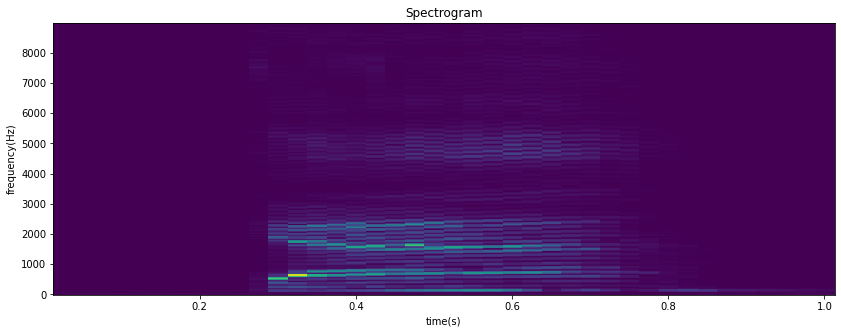

In [5]:
#Spectogram
pyplot.rcParams['figure.figsize'] = 14,5
pyplot.pcolormesh(t, f[:450], S1[:450][:])
pyplot.title("Spectrogram")
xlabel('time(s)')
ylabel('frequency(Hz)')
show()

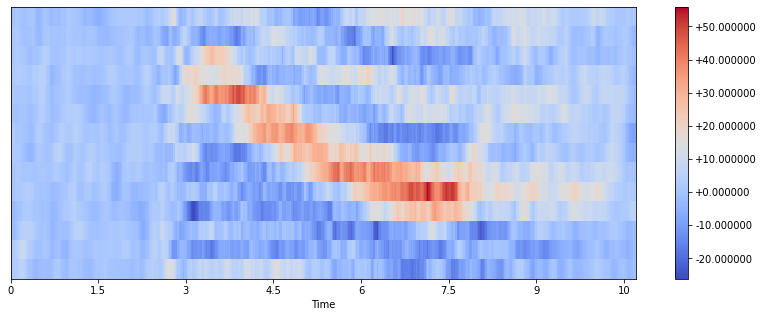

In [11]:
#Visualie MFCC 
#pyplot.rcParams['figure.figsize'] = 14,5
plt.figure(figsize=(14,5))
sr = fs
librosa.display.specshow(mfccs[28:],x_axis='time',sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [ ]:
#Calculate Delta and delta2 MFCCs

delta_mfccs=librosa.feature.delta(mfccs)
delta2_mfccs=librosa.feature.delta(mfccs, order=2)

In [ ]:
delta_mfccs.shape

In [ ]:
mfccs.shape

In [ ]:
#First Derivative of MFCCs
plt.figure(figsize=(14,5))
librosa.display.specshow(delta_mfccs[1:],x_axis='time',sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [ ]:
#Second Derivatives of MFCCs

plt.figure(figsize=(14,5))
librosa.display.specshow(delta2_mfccs,x_axis='time',sr=sr)
plt.colorbar(format="%+2f")
plt.show()